In [1]:
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from cfmining.algorithms import MAPOCAM, BruteForce, Greedy
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier
from cfmining.visualization import buildTable, PlotCounterfactuals
from cfmining.mip_builder import RecourseBuilder
from cfmining.action_set import ActionSet

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

## Probability threshold

In [3]:
prob = 0.78

# Read in the data

In [4]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Diabetes']

pima_df = pd.read_csv('data/pima/pima-indians-diabetes.data.csv', header=None)
pima_df.columns = cols
pima_df = pima_df.astype({'BMI': 'int32'})
y = 1-pima_df['Diabetes']
X = pima_df.drop('Diabetes', axis=1)
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
0,6,148,72,35,0,33,0.627,50,1
1,1,85,66,29,0,26,0.351,31,0
2,8,183,64,0,0,23,0.672,32,1
3,1,89,66,23,94,28,0.167,21,0
4,0,137,40,35,168,43,2.288,33,1


In [5]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=100, random_state=4007)

# Train model

In [6]:
## grid search
clf_logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
grid = GridSearchCV(
  clf_logreg, param_grid={'C': np.logspace(-12, 12, num=25)},
  cv=5,
  scoring='roc_auc',
)
grid.fit(Xtr, ytr)
clf_logreg = grid.best_estimator_

In [7]:
print('AUC performance:', roc_auc_score(yts, clf_logreg.predict(Xts)))

AUC performance: 0.7584803256445047


## Preparing classifiers to be actionable

In [8]:
clf_logreg_ = MonotoneClassifier(clf_logreg, Xtr, ytr, threshold=prob)
coefficients = clf_logreg.coef_[0]
intercept = clf_logreg.intercept_[0]

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Preparing action set

In [9]:
action_set = ActionSet(X = X)
action_set.embed_linear_clf(coefficients=coefficients)

for feat in action_set:
    feat.step_type ="relative"
    feat.step_size = 0.1
    feat.update_grid()
    
action_set['Age'].mutable = False
action_set['DiabetesPedigreeFunction'].mutable = False
action_set['Pregnancies'].mutable = False

In [10]:
pd_coef = pd.Series(coefficients, index=X.columns).to_frame('Coefficients')
pd_coef

,Coefficients
Pregnancies,-0.111772
Glucose,-0.034837
BloodPressure,0.017018
SkinThickness,-0.002121
Insulin,0.000570
BMI,-0.083952
DiabetesPedigreeFunction,-0.376352
Age,-0.019132


## Preparing sample to be actionable

In [11]:
scores = pd.Series(clf_logreg.predict_proba(X)[:, 1])
denied_individuals = scores.loc[lambda s: (s < prob)].index

In [12]:
choice = 162
choice = choice if choice in denied_individuals else np.random.choice(denied_individuals)
print('Choice:', choice)
individual = X.loc[choice].values

Choice: 162


## Preparing criteria

In [13]:
percCalc = PercentileCalculator(action_set=action_set)
percCriteria = PercentileCriterion(individual, percCalc)
percChCriteria = PercentileChangesCriterion(individual, percCalc)

## Generate original counterfactual

In [14]:
p = prob
start = time.perf_counter()
rb = RecourseBuilder(
      optimizer="cplex",
      coefficients=coefficients,
      intercept=intercept- (np.log(p / (1. - p))),
      action_set=action_set,
      x=individual
)

build_info, indices = rb._get_mip_build_info()
output_1 = rb.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.04754770640283823


In [15]:
print('Number of actions', sum(output_1['actions']!=0))
(pd.Series(output_1['actions']+individual, index=X.columns).iloc[output_1['actions']!=0].to_frame('Actions')).replace(0,'-')

Number of actions 3


,Actions
Glucose,113.0
Insulin,468.0
BMI,42.0


## Enumerate recourse

In [16]:
en_nd_feat = MAPOCAM(action_set, individual, clf_logreg_, max_changes=3)
start = time.perf_counter()
en_nd_feat.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.022248759865760803


## Counterfactual summary

In [17]:
names = action_set.df['name'].values
overview_clean = buildTable(en_nd_feat, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_feat, individual, percCriteria, names, include_original=True, include_cost=True)

In [18]:
overview_full.replace(np.nan, '-')

,Orig,C1,C2,C3,C4,...,C8,C9,C10,C11,C12
Pregnancies,0,-,-,-,-,...,-,-,-,-,-
Glucose,114,113,-,113,-,...,-,-,-,-,-
BloodPressure,80,-,-,88,88,...,-,88,-,88,-
SkinThickness,34,-,-,-,-,...,24,24,12,12,0
Insulin,285,468,520,520,-,...,468,520,416,468,364
BMI,44,42,42,-,42,...,42,-,42,-,42
DiabetesPedigreeFunction,0.167,-,-,-,-,...,-,-,-,-,-
Age,27,-,-,-,-,...,-,-,-,-,-
Cost,-,-,-,-,-,...,-,-,-,-,-


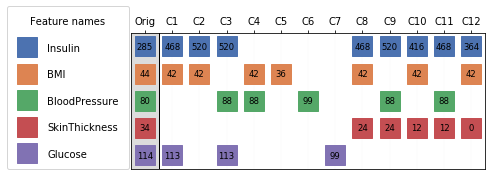

In [19]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show('plot/pima_enum.pdf')

## Another non-dominate criterion

In [20]:
en_nd_pc = MAPOCAM(action_set, individual, clf_logreg_, max_changes=np.inf, compare=percChCriteria)
start = time.perf_counter()
en_nd_pc.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.07545226812362671


In [21]:
overview_clean = buildTable(en_nd_pc, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_pc, individual, percCriteria, names, include_original=True, include_cost=True)

In [22]:
overview_full.replace(np.nan, '-')

,Orig,C1,C2,C3
Pregnancies,0,-,-,-
Glucose,114,113,-,-
BloodPressure,80,-,-,-
SkinThickness,34,-,-,-
Insulin,285,468,520,-
BMI,44,42,42,36
DiabetesPedigreeFunction,0.167,-,-,-
Age,27,-,-,-
Cost,-,-,-,-


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

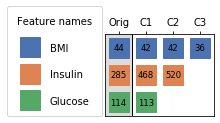

In [23]:
pltW = PlotCounterfactuals(overview_clean, individual)
pltW.show('plot/pc_pima.eps')